#### Imports

In [8]:
from optimizers import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt

#### Helper functions

In [9]:
_infty = 1e16
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr > _infty] = _infty
    arr[arr == 0] = _zero
    arr[arr < _zero] = _zero
    return arr

# A more complicated function

$$ M = 6, N = 10, F : \R^M \to \R^N$$

$$ F(x) = \begin{bmatrix}
    \sin(x_1) + \cos(2x_1) - 1 \\
    10\cos(-2x_2 + 1) + 3 \\
    2 \exp((x_3 + 10) / ||x||_2) \\
    \exp(\sin(\pi/2 + ||x||_2)) - 10 \\
    \left(\ln\left(3 + \left|\sum_{i=1}^{M} x_i\right|\right) - 1\right)^2 \\
    \cos(\exp(\sin^2(x_5))) \\
    5\left(\sin\left(\sqrt{|\sum_{i=1}^M x_i|} - 1\right)\right)^2 + 1\\
    \sqrt{|\cos(\exp(\sin(x_8)))|} \\
    ||x||_2^2 - 5 \\
    |\sum_{i=1}^M x_i| - 1
\end{bmatrix}$$

In [10]:
M = 6
sin = Function(F=np.sin, DF=lambda x: np.cos(x), D2F=lambda x: -np.sin(x), M=1, N=1)
cos = Function(F=np.cos, DF=lambda x: -np.sin(x), D2F=lambda x: -np.cos(x), M=1, N=1)
exp = Function(F=np.exp, DF=np.exp, D2F=np.exp, M=1, N=1)
log = Function(F=lambda x: np.log(np.abs(x)), DF=lambda x: 1 / x, D2F=lambda x: -1 / x**2, M=1, N=1)
square = Function(F=lambda x: x**2, DF=lambda x: 2 * x, D2F=lambda x: 2 * np.eye(1), M=1, N=1)
abs = Function(F=np.abs, DF=lambda x: np.sign(x), D2F=lambda x: np.zeros_like(x), M=1, N=1)
sqrt = Function(F=lambda x: np.sqrt(np.abs(x)), DF=lambda x: 1 / (2 * np.sqrt(np.abs(x))) * np.sign(x), D2F=lambda x: - 1 / (4 * np.abs(x)**(3 / 2)), M=1, N=1)
norm_sqr = Function(F=lambda x: np.array(np.linalg.norm(x)**2), DF=lambda x: 2 * x, D2F=lambda x: 2 * np.eye(len(x)), M=M, N=1)
sum_ = Function(F=np.sum, DF=lambda x: np.ones_like(x), D2F=lambda _: np.zeros((M, M)), M=M, N=1)
proj = lambda k: Function(F=lambda x: x[k], DF=lambda x: np.eye(M)[k], D2F=lambda x: np.zeros((len(x), len(x))), M=M, N=1)
constM = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(M), D2F=lambda _: np.zeros((M, M)), M=M, N=1)
const1 = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(1), D2F=lambda _: np.zeros((1, 1)), M=1, N=1)
mul_const = lambda c: Function(F=lambda x: c * x, DF=lambda x: c * np.eye(1), D2F=lambda x: np.zeros(1), M=1, N=1)

F1 = compose(proj(0), sin + compose(mul_const(2), cos)) - constM(1)
F2 = compose(proj(1), mul_const(-2) + const1(1), const1(10) * cos) + constM(3)
F3 = compose((proj(2) + constM(10)) / norm_sqr, 2 * exp)
F4 = compose(norm_sqr + constM(np.pi / 2), sin, exp) - constM(10)
F5 = compose(compose(sum_, abs) + constM(3), log - const1(1), square)
F6 = compose(proj(4), sin, square, exp, cos)
F7 = compose(sum_, sqrt - const1(1), sin, const1(5) * square) + constM(1)
F8 = compose(proj(5), sin, exp, cos, const1(2) - const1(5) * sqrt)
F9 = norm_sqr - constM(5)
F10 = compose(sum_, abs) - constM(1)
F = stack(F1, F2, F3, F4, F5, F6, F7, F8, F9, F10)

# Performance tests

## Hyperparameters

In [12]:
np.random.seed(42)
p0 = np.random.randn(M)
max_iter = 1000
alpha_gn = 1e-2
max_iter_gd = 10000
alpha_gd = 1e-8
p0

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696])

## Gradient descent method

In [13]:
p, err = gradient_descent(F, p0, alpha_gd, max_iter_gd)
print(f"{p=}\n{err=}")

p=array([ 0.58892572, -0.17571376,  0.73618135,  1.80676449, -0.27834888,
       -0.27794419])
err=26.286827379742146


## Gauss-Newton method

In [14]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, step_type="cholesky")
print(f"{p=}\n{err=}")

p=array([ 0.80640294, -0.42920596, -1.99814989,  0.99704934,  0.85057287,
        0.36877008])
err=10.231830201450641


In [15]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=alpha_gn, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([ 0.80640294, -0.42920596, -1.99814989,  0.99704934,  0.85057287,
        0.36877008])
err=10.231830201450641


## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [16]:
lambda_param = 1.
optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)

In [17]:
p, err = optimizer.optimize(p0, max_iter, step_type="cholesky")
print(f"{p=}\n{err=}")

p=array([ 0.27286898, -0.43379808, -2.13663756,  0.07472363,  0.46300625,
        0.34938581])
err=12.52471298079969


In [18]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([ 0.60827758, -0.43880488, -2.70916911,  0.51983969,  0.82475316,
        0.35443203])
err=11.371425393678264


In [19]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=6, step_tol=1e-6)
print(f"{p=}\n{err=}")

p=array([ 0.519149  , -0.43556215, -2.44785453,  0.49467552,  0.67616276,
        0.35291085])
err=10.327822125949666


In [20]:
p, err = optimizer.optimize(p0, max_iter, step_type="svd")
print(f"{p=}\n{err=}")

p=array([ 0.42300224, -0.43620476, -2.62798127,  0.44159214,  0.64832285,
        0.35064791])
err=10.914537737340044


#### 2. Adaptive $\lambda_k$ sequence

In [21]:
optimizer = LevenbergMarquardt(
    R=F,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=1., lambda_change=1.1),
)

In [22]:
p, err = optimizer.optimize(p0, max_iter, step_type="cholesky")
print(f"{p=}\n{err=}")

p=array([ 0.80640359, -0.42921601, -1.99814643,  0.99704952,  0.85057338,
        0.36877472])
err=10.231830199520209


In [23]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}\n{err=}")

p=array([ 0.80640357, -0.42921601, -1.99814643,  0.99704955,  0.85057337,
        0.36877471])
err=10.231830199520205


In [24]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=6, step_tol=1e-6)
print(f"{p=}\n{err=}")

p=array([ 0.38412218, -0.43302255, -2.40298224,  0.3640756 ,  0.50627041,
        0.35123186])
err=9.942936267695863


In [25]:
p, err = optimizer.optimize(p0, max_iter, step_type="svd")
print(f"{p=}\n{err=}")

p=array([ 0.80640354, -0.42921601, -1.99814643,  0.99704958,  0.85057336,
        0.36877471])
err=10.231830199520202


# Test number of iterations

In [27]:
max_iters = [2**i for i in range(0, 13)]
np.random.seed(42)
p0s = [4**i * np.random.randn(M) for i in range(3)]
alpha_gd = 1e-5
alpha_gn = 1e-2
lambda0 = 1.
lambda_change = 1.1
step_max_iter = 10
step_tol = 1e-6

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []
errors_newton = []

for i, max_iter in enumerate(max_iters):
    print(f"max_iter: {max_iter} ({i + 1}/{len(max_iters)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

    errs = []
    for p0 in p0s:
        p, err = newton(R=F, p0=p0, max_iter=max_iter)
        errs.append(err)
    errors_newton.append(errs)

max_iter: 1 (1/13)
max_iter: 2 (2/13)
max_iter: 4 (3/13)


max_iter: 8 (4/13)
max_iter: 16 (5/13)
max_iter: 32 (6/13)
max_iter: 64 (7/13)
max_iter: 128 (8/13)


KeyboardInterrupt: 

In [ ]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

errors_newton_mean = np.mean(errors_newton, axis=1)
errors_newton_mean = remove_nans_infs_and_zeros(errors_newton_mean)

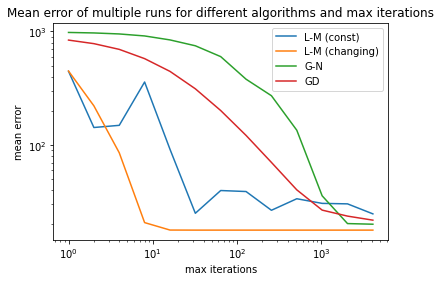

In [ ]:
plt.loglog(max_iters, errors_mean_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_mean_lm_mod, label="L-M (changing)")
plt.loglog(max_iters, errors_gn_mean, label="G-N")
plt.loglog(max_iters, errors_gd_mean, label="GD")
plt.loglog(max_iters, errors_newton_mean, label="Newton")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and max iterations")
plt.show()

In [ ]:
errors_min_lm_const = np.min(errors_levenberg_marquardt_const_param, axis=1)
errors_min_lm_const = remove_nans_infs_and_zeros(errors_min_lm_const)

errors_min_lm_mod = np.min(errors_levenberg_marquardt_modifying_param, axis=1)
errors_min_lm_mod = remove_nans_infs_and_zeros(errors_min_lm_mod)

errors_gn_min = np.min(errors_gauss_newton, axis=1)
errors_gn_min = remove_nans_infs_and_zeros(errors_gn_min)

errors_gd_min = np.min(errors_gradient_descent, axis=1)
errors_gd_min = remove_nans_infs_and_zeros(errors_gd_min)

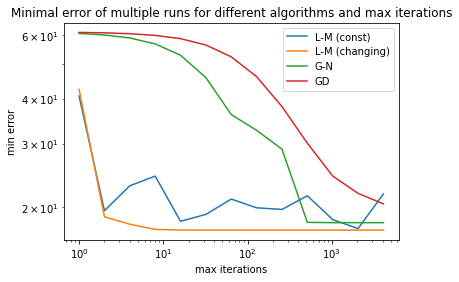

In [ ]:
plt.loglog(max_iters, errors_min_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_min_lm_mod, label="L-M (changing)")
plt.loglog(max_iters, errors_gn_min, label="G-N")
plt.loglog(max_iters, errors_gd_min, label="GD")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("min error")
plt.title("Minimal error of multiple runs for different algorithms and max iterations")
plt.show()

In [ ]:
max_iters = [2**i for i in range(0, 13)]
np.random.seed(42)
p0s = [2**i * np.random.randn(M) for i in range(10, 12)]
alpha_gd = 1e-12
alpha_gn = 1e-2
lambda0 = 1.
lambda_change = 1.1
step_max_iter = 10
step_tol = 1e-6

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, max_iter in enumerate(max_iters):
    print(f"max_iter: {max_iter} ({i + 1}/{len(max_iters)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=F, p0=p0, alpha=alpha_gn, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=F, p0=p0, alpha=alpha_gd, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

max_iter: 1 (1/13)
max_iter: 2 (2/13)
max_iter: 4 (3/13)
max_iter: 8 (4/13)
max_iter: 16 (5/13)
max_iter: 32 (6/13)
max_iter: 64 (7/13)
max_iter: 128 (8/13)
max_iter: 256 (9/13)
max_iter: 512 (10/13)
max_iter: 1024 (11/13)
max_iter: 2048 (12/13)
max_iter: 4096 (13/13)


In [ ]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

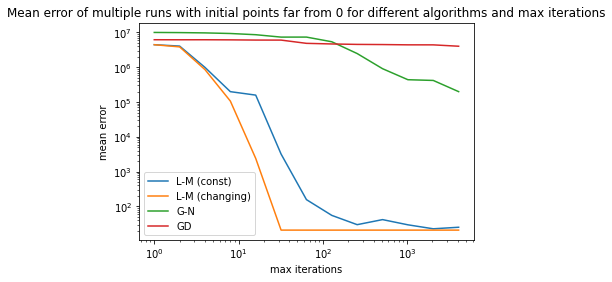

In [ ]:
plt.loglog(max_iters, errors_mean_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_mean_lm_mod, label="L-M (changing)")
plt.loglog(max_iters, errors_gn_mean, label="G-N")
plt.loglog(max_iters, errors_gd_mean, label="GD")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs with initial points far from 0 for different algorithms and max iterations")
plt.show()

In [ ]:
errors_min_lm_const = np.min(errors_levenberg_marquardt_const_param, axis=1)
errors_min_lm_const = remove_nans_infs_and_zeros(errors_min_lm_const)

errors_min_lm_mod = np.min(errors_levenberg_marquardt_modifying_param, axis=1)
errors_min_lm_mod = remove_nans_infs_and_zeros(errors_min_lm_mod)

errors_gn_min = np.min(errors_gauss_newton, axis=1)
errors_gn_min = remove_nans_infs_and_zeros(errors_gn_min)

errors_gd_min = np.min(errors_gradient_descent, axis=1)
errors_gd_min = remove_nans_infs_and_zeros(errors_gd_min)

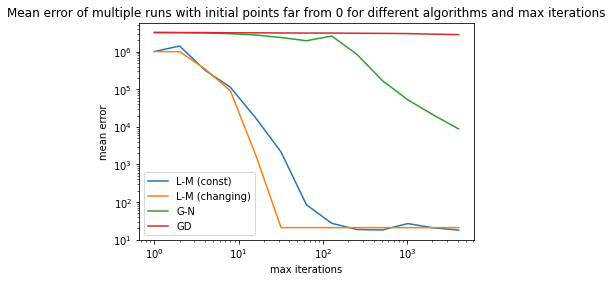

In [ ]:
plt.loglog(max_iters, errors_min_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_min_lm_mod, label="L-M (changing)")
plt.loglog(max_iters, errors_gn_min, label="G-N")
plt.loglog(max_iters, errors_gd_min, label="GD")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs with initial points far from 0 for different algorithms and max iterations")
plt.show()

# Test CGNR parameters for Levenberg-Marquardt method

## Test CGNR tolerance

In [ ]:
step_tols = [float(10**i) for i in range(-12, 2)]
np.random.seed(42)
p0s = [2**i * np.random.randn(M) for i in range(5)]
max_iter = 100
step_max_iter = 100
lambda0 = 1.

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []

for i, step_tol in enumerate(step_tols):
    print(f"step_tol: {step_tol} ({i + 1}/{len(step_tols)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

step_tol: 1e-12 (1/14)
step_tol: 1e-11 (2/14)
step_tol: 1e-10 (3/14)
step_tol: 1e-09 (4/14)
step_tol: 1e-08 (5/14)
step_tol: 1e-07 (6/14)
step_tol: 1e-06 (7/14)
step_tol: 1e-05 (8/14)
step_tol: 0.0001 (9/14)
step_tol: 0.001 (10/14)
step_tol: 0.01 (11/14)
step_tol: 0.1 (12/14)
step_tol: 1.0 (13/14)
step_tol: 10.0 (14/14)


In [ ]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

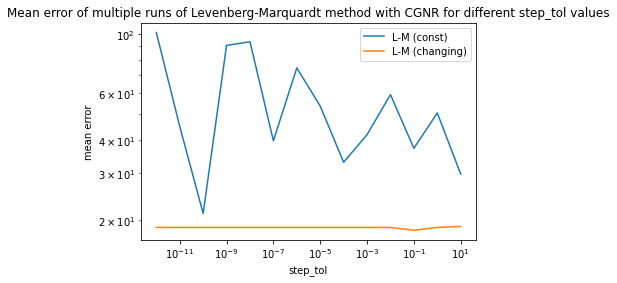

In [ ]:
plt.loglog(step_tols, errors_mean_lm_const, label="L-M (const)")
plt.loglog(step_tols, errors_mean_lm_mod, label="L-M (changing)")

plt.legend()
plt.xlabel("step_tol")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs of Levenberg-Marquardt method with CGNR for different step_tol values")
plt.show()

## Test CGNR max iterations

In [ ]:
step_tol = 1e-8
np.random.seed(42)
p0s = [2**i * np.random.randn(M) for i in range(5)]
max_iter = 100
step_max_iters = [2**i for i in range(8)]

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []

for i, step_max_iter in enumerate(step_max_iters):
    print(f"step_max_iter: {step_max_iter} ({i + 1}/{len(step_max_iters)})")
    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

step_max_iter: 1 (1/8)
step_max_iter: 2 (2/8)
step_max_iter: 4 (3/8)
step_max_iter: 8 (4/8)
step_max_iter: 16 (5/8)
step_max_iter: 32 (6/8)
step_max_iter: 64 (7/8)
step_max_iter: 128 (8/8)


In [ ]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

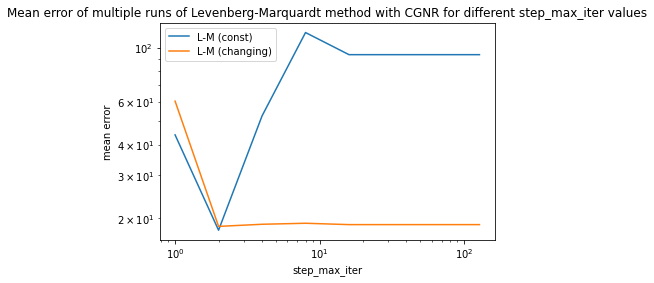

In [ ]:
plt.loglog(step_max_iters, errors_mean_lm_const, label="L-M (const)")
plt.loglog(step_max_iters, errors_mean_lm_mod, label="L-M (changing)")

plt.legend()
plt.xlabel("step_max_iter")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs of Levenberg-Marquardt method with CGNR for different step_max_iter values")
plt.show()